In [1]:
!nvidia-smi

Sat Jun 11 13:30:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.156.00   Driver Version: 450.156.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:39:00.0 Off |                    0 |
| N/A   39C    P0    53W / 350W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install transformers==4.10.3

In [3]:
#!pip install seaborn

In [4]:
#!pip install pytextspan razdel

In [104]:
#!pip install sklearn_crfsuite

     |████████████████████████████████| 965 kB 1.4 MB/s            


In [5]:
#!pip install seqeval

In [6]:
import transformers
transformers.__version__

2022-06-11 13:30:33.513656: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


'4.10.3'

In [99]:
import torch
import numpy as np
from tqdm import tqdm
import sys
import os
import pickle
import random
from dataclasses import dataclass, field
from typing import List, Dict, Union
import json
import re
import pandas as pd
import razdel
import textspan
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seqeval.metrics import f1_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer  


# sys.path.append('..')
# from generate import generate
# from dataset import get_single_file_dataloader, get_multi_file_dataloader
# from inference import load_mgpt_xl, load_mgpt_13b, load_rugpt_xl

import warnings
warnings.simplefilter("ignore")

In [8]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/mGPT")
model = GPT2LMHeadModel.from_pretrained("sberbank-ai/mGPT")

# model = load_mgpt_13b('/home/jovyan/MGPT13b/multilingual3_1_tune512_28_84000_merged/')

In [9]:
import torch
device = torch.device('cuda')

In [10]:
model=model.to(device)

In [11]:
!pwd

/home/jovyan/olga_experiments


In [125]:
train_lang = 'en'
prompts = {0: "<s>lang: ", 1: "\nTagged sentence: ", 2: '</s>'}
def format_train_data(sent):
    sent = sent.replace('\n','@@@')
    sent = re.sub(r'\s+', ' ', sent)
    sent = sent.replace(' ','_')
    sent = ' '.join(random.choices(re.sub('@@@', ' ', sent).strip().split(), k=45))
    result = prompts[0] +train_lang+ prompts[1] +sent+ prompts[2]
    return result

def format_test_data(sent, i, lang):
    sent = sent.replace('\n','@@@')
    sent = re.sub(r'\s+', ' ', sent)
    sent = sent.replace(' ','_')
    sent = re.sub('@@@', ' ', sent).strip().split()
    result = prompts[0] +lang+ prompts[1] +' '.join(sent[:i]) + ' ' \
             + sent[i].split('_')[0] + '_'
    return ' '.join(sent[:i]) + ' ' + sent[i].split('_')[0] + '_'

#en_data = format_train_data(open("en_data/train.txt").read())

In [126]:
tagset = {line.strip().split()[-1] for line in open("en_data/train.txt") if line.strip()}

In [127]:
en_data = format_test_data(open("en_data/test.txt").read(), 80, 'en')

In [128]:
#СЧИТАЕМ ДЛЯ АНГЛИЙСКОГО

In [129]:
data = pd.read_csv("ner_data_csv/en_train_translated_new.csv", encoding="utf-8", nrows=100).fillna(method="ffill")

In [130]:
clean_texts_en = [w for w in data["tokens"]]
#print(clean_texts_en)

In [131]:
valid_tags_en = [eval(s) for s in data["BIO"]]
#print(valid_tags_en)

In [132]:
def hypotheses(sent):
    pref = en_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [133]:
pred_tags_en = []
for text in tqdm(clean_texts_en):    
    pred_tags_en.append(get_ner(text))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [07:37<00:00,  4.58s/it]


In [134]:
print(f1_score(pred_tags_en, valid_tags_en))

0.6294416243654822


In [135]:
print(classification_report(pred_tags_en, valid_tags_en, digits=2))

              precision    recall  f1-score   support

        area       0.88      0.65      0.75        23
        food       0.97      0.57      0.72        49
        name       0.00      0.00      0.00         0
  pricerange       0.78      0.56      0.65        25
        this       0.71      0.18      0.29        28

   micro avg       0.86      0.50      0.63       125
   macro avg       0.67      0.39      0.48       125
weighted avg       0.86      0.50      0.61       125



In [136]:
from sklearn_crfsuite.metrics import flat_classification_report
print(flat_classification_report(pred_tags_en, valid_tags_en))

              precision    recall  f1-score   support

      B-area       0.88      0.65      0.75        23
      B-food       0.97      0.57      0.72        49
      B-name       0.00      0.00      0.00         0
B-pricerange       0.78      0.56      0.65        25
      B-this       1.00      0.32      0.48        22
      I-food       0.00      0.00      0.00         1
      I-name       0.00      0.00      0.00         0
      I-this       0.88      0.39      0.54        18
           O       0.86      0.99      0.92       358

    accuracy                           0.86       496
   macro avg       0.60      0.39      0.45       496
weighted avg       0.87      0.86      0.85       496



In [137]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_en)
valid_tags = MultiLabelBinarizer().fit_transform(valid_tags_en)

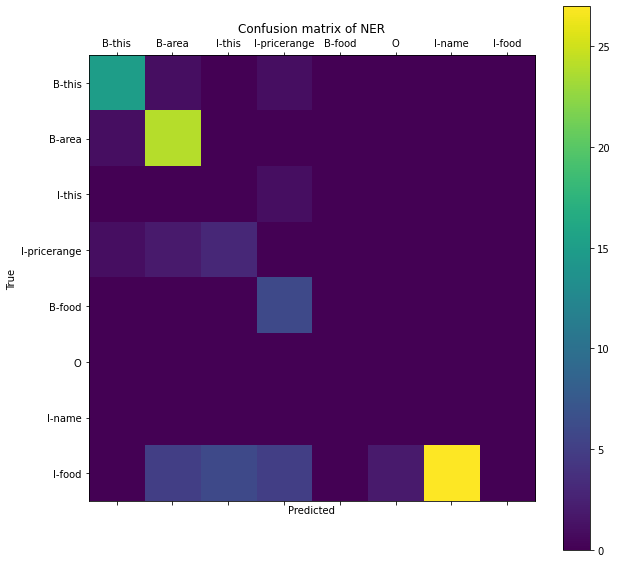

In [138]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm)
plt.title('Confusion matrix of NER')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(tagset))
ax.set_yticklabels([''] + list(tagset))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

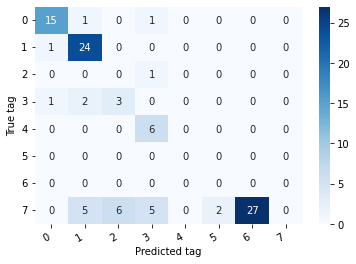

In [139]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True tag')
    plt.xlabel('Predicted tag');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [140]:
#СЧИТАЕМ ДЛЯ НЕМЕЦКОГО

In [141]:
de_data = format_test_data(open("de_data/test.txt").read(), 80, 'de')
print(de_data)

äh_O ja_O ich_O suche_O ein_O günstiges_B-pricerange Restaurant_O im_O westlichen_B-area Teil_O der_O Stadt_O Westen_B-area äh_O ja_O ein_O billiges_B-pricerange Restaurant_O äh_O es_O spielt_I-this keine_B-this Rolle_I-this okay_O und_O äh_O was_O ist_O ihre_O Telefonnummer_O bitte_O okay_O und_O ähm_O danke_O und_O auf_O Wiedersehen_O Ich_O suche_O ein_O Restaurant_O im_O westlichen_B-area Teil_O der_O Stadt_O das_O italienische_B-food Küche_O serviert_O Spielt_B-this keine_I-this Rolle_I-this Ist_B-this mir_I-this egal_I-this Wie_O lautet_O die_O Telefonnummer_O Wie_O lautet_O die_O Adresse_O was_O ist_O die_O Preisspanne_O Vielen_O Dank_O auf_O Närt_O Ich_O würde_O gerne_O ein_O preisgünstiges_B-pricerange Restaurant_O im_O nördlichen_


In [142]:
clean_texts_de = [w for w in data["translation"]]
#print(clean_texts_de)

In [143]:
valid_tags_de = [eval(s) for s in data["BIO_list_trans"]]
#print(valid_tags_en)

In [144]:
def hypotheses(sent):
    pref = de_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [145]:
pred_tags_de = []
for text in tqdm(clean_texts_de):    
    pred_tags_de.append(get_ner(text))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [08:17<00:00,  4.97s/it]


In [146]:
print(f1_score(pred_tags_de, valid_tags_de))

0.35555555555555557


In [147]:
print(classification_report(pred_tags_de, valid_tags_de, digits=2))

              precision    recall  f1-score   support

        area       0.88      0.20      0.33        74
        food       0.65      0.65      0.65        31
        name       0.00      0.00      0.00         0
  pricerange       0.53      0.53      0.53        19
        this       0.33      0.04      0.08        69

   micro avg       0.62      0.25      0.36       193
   macro avg       0.48      0.28      0.32       193
weighted avg       0.61      0.25      0.31       193



In [148]:
print(flat_classification_report(pred_tags_de, valid_tags_de))

              precision    recall  f1-score   support

      B-area       0.88      0.20      0.33        74
      B-food       0.65      0.65      0.65        31
      B-name       0.00      0.00      0.00         0
B-pricerange       0.53      0.53      0.53        19
      B-this       0.43      0.60      0.50         5
      I-name       0.00      0.00      0.00         0
      I-this       0.90      0.06      0.11       157
           O       0.48      1.00      0.65       184

    accuracy                           0.51       470
   macro avg       0.48      0.38      0.34       470
weighted avg       0.70      0.51      0.41       470



In [149]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_de)
valid_tags = MultiLabelBinarizer().fit_transform(valid_tags_de)

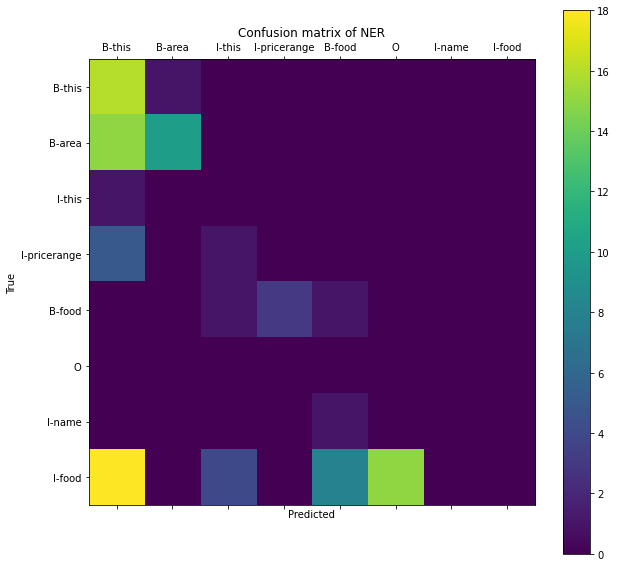

In [150]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm)
plt.title('Confusion matrix of NER')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(tagset))
ax.set_yticklabels([''] + list(tagset))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

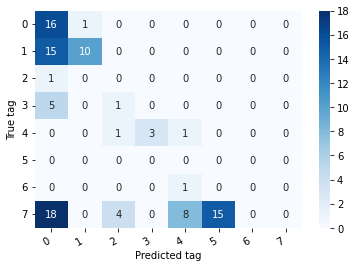

In [151]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True tag')
    plt.xlabel('Predicted tag');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [152]:
#СЧИТАЕМ ДЛЯ РУССКОГО

In [153]:
ru_data = format_test_data(open("ru_data/valid.txt").read(), 80, 'ru')
ru_data

'сил_O северная_B-area часть_O города_O где_O подают_O гастропаб_O А_O как_O насчет_O китайского_B-food ресторана_O на_O севере_B-area города_O подают_O ли_O они_O китайскую_B-food еду_O только_O китайская_B-food еда_O в_O северной_B-area части_O города_O Меня_O не_O волнует_O каков_O их_O номер_O телефона_O спасибо_O до_O свидания_O шум_O Я_O ищу_O ресторан_O по_O умеренной_O цене_O и_O он_O должен_O подавать_O полинезийскую_O кухню_B-food в_O умеренной_B-pricerange цене_O да_O как_O насчет_O индийской_B-food кухни_O А_O как_O насчет_O индийского_B-food как_O насчет_O индийского_B-food типа_O пищи_O нет_O индийской_B-food кухни_O смеяться_O индийский_B-food Я_O ищу_O румынскую_B-food еду_O в_O дорогом_B-pricerange ценовом_O диапазоне_O Не_'

In [154]:
def tokenize(text):
    tokens, spans = [], []
    for tok_and_span in razdel.tokenize(text):
        tokens.append(tok_and_span.text)
        spans.append((tok_and_span.start, tok_and_span.stop-1))
    return tokens, spans


def tokenize_w_spans(text, tokens=None):
    tokens,_ = tokenize(text)
    spans = [el[0] for el in textspan.get_original_spans(tokens, text)]
    return tokens, spans


def get_token_ix_by_character_ix(ix, text, tokens):
    tokens, spans = tokenize_w_spans(text, tokens)
    for token_ix, (token, (span_start, span_end)) in enumerate(zip(tokens, spans)):
        if span_start <= ix <= span_end:
            return token_ix


def translated_ix2orig_ix(translated_ix, proj):
    or_span2tr_span4toks = [tuple(tuple(map(int, el.split(':'))) for el in orig2trns.split('-')) 
                            for orig2trns in proj.split()]
    
    for ix, (or_tok_span, (tr_start, tr_end)) in enumerate(or_span2tr_span4toks):
        if tr_start <= translated_ix <= tr_end:
            return ix, or_tok_span


def tok_old2tok_new(row):
    tokens, spans = tokenize_w_spans(row["translation"])
    token_tags = []
    for token, (tok_start, tok_end) in zip(tokens, spans):
        token_counterpart = translated_ix2orig_ix(tok_start, eval(row["translated"])["alignment"]["proj"])
        if token_counterpart is None:
            token_tag='O'
        else:
            counterpart_ix, counterpart_span = token_counterpart
            c_ix = counterpart_span[0]
            if counterpart_span[0]>len(row["tokens"]):
                last_c_ix = len(row["tokens"])-1
                c_ix=last_c_ix
            token_ix = get_token_ix_by_character_ix(c_ix, row["tokens"], eval(row["tokens_list"]))
            
            token_tag = eval(row["BIO"])[token_ix]
            
        token_tags.append(token_tag)
    
    return str(tokens), str(token_tags)

In [155]:
data_ru = pd.read_csv("ner_data_csv/ru_train_translated_new.csv", encoding="utf-8", nrows=120).fillna(method="ffill")

In [156]:
data_ru[["translated_tokens", "translated_tags"]] = data_ru.apply(lambda row: pd.Series(tok_old2tok_new(row)), 
                                                        axis=1)

In [157]:
valid_tags_ru = [eval(s) for s in data_ru["translated_tags"]]

In [158]:
clean_texts = [w for w in data_ru["translation"]]
clean_texts_ru = []
for txt in clean_texts:
    if ',' in txt:
        clean_texts_ru.append(txt.replace(',',''))
    else:
        clean_texts_ru.append(txt)

In [159]:
final_texts_ru=[]
final_tags_ru=[]
for txt, t in zip(clean_texts_ru, valid_tags_ru):
    if len(txt.split())!=len(t):
        print('aaa')
    else:
        final_texts_ru.append(txt)
        final_tags_ru.append(t)

aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa


In [160]:
def hypotheses(sent):
    pref = ru_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [161]:
pred_tags_ru = []
for text in tqdm(final_texts_ru):    
    pred_tags_ru.append(get_ner(text))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [06:08<00:00,  3.69s/it]


In [162]:
print(f1_score(pred_tags_ru, final_tags_ru))

0.46706586826347307


In [163]:
print(classification_report(pred_tags_ru, final_tags_ru, digits=2))

              precision    recall  f1-score   support

        area       0.16      1.00      0.27         3
        food       0.86      0.65      0.74        37
  pricerange       1.00      0.19      0.32        64
        this       0.00      0.00      0.00         0

   micro avg       0.62      0.38      0.47       104
   macro avg       0.50      0.46      0.33       104
weighted avg       0.92      0.38      0.46       104



In [164]:
print(flat_classification_report(pred_tags_ru, final_tags_ru))

              precision    recall  f1-score   support

      B-area       0.16      1.00      0.27         3
      B-food       0.86      0.65      0.74        37
B-pricerange       1.00      0.19      0.32        64
      B-this       0.00      0.00      0.00         0
      I-this       0.00      0.00      0.00         0
           O       0.83      0.98      0.90       226

    accuracy                           0.79       330
   macro avg       0.47      0.47      0.37       330
weighted avg       0.86      0.79      0.76       330



In [165]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_ru)
valid_tags = MultiLabelBinarizer().fit_transform(final_tags_ru)

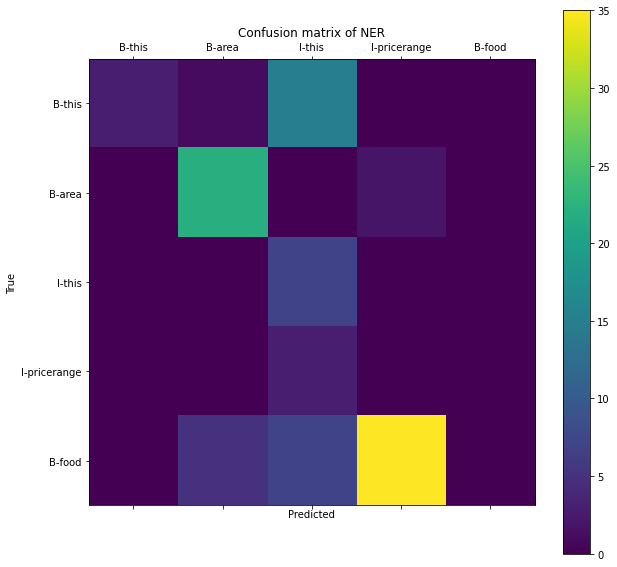

In [166]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm)
plt.title('Confusion matrix of NER')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(tagset))
ax.set_yticklabels([''] + list(tagset))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

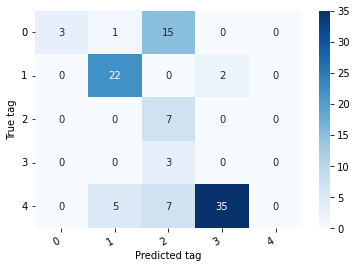

In [167]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True tag')
    plt.xlabel('Predicted tag');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [168]:
#EN-DE

In [169]:
def hypotheses(sent):
    pref = en_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [170]:
pred_tags_en_de = []
for text in tqdm(clean_texts_de):    
    pred_tags_en_de.append(get_ner(text))
print(f1_score(pred_tags_en_de, valid_tags_de))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.36s/it]

0.5196078431372548


In [171]:
print(classification_report(pred_tags_en_de, valid_tags_de, digits=2))

              precision    recall  f1-score   support

        area       0.59      0.38      0.47        26
        food       0.84      0.54      0.66        48
        name       0.00      0.00      0.00         0
  pricerange       0.68      0.50      0.58        26
        this       0.44      0.15      0.22        27

   micro avg       0.69      0.42      0.52       127
   macro avg       0.51      0.31      0.38       127
weighted avg       0.67      0.42      0.51       127



In [172]:
print(flat_classification_report(pred_tags_en_de, valid_tags_de))

              precision    recall  f1-score   support

      B-area       0.59      0.38      0.47        26
      B-food       0.84      0.54      0.66        48
      B-name       0.00      0.00      0.00         0
B-pricerange       0.68      0.50      0.58        26
      B-this       0.29      0.13      0.18        15
      I-food       0.00      0.00      0.00        14
      I-name       0.00      0.00      0.00         0
      I-this       0.90      0.20      0.33        44
           O       0.74      0.95      0.83       297

    accuracy                           0.73       470
   macro avg       0.45      0.30      0.34       470
weighted avg       0.71      0.73      0.69       470



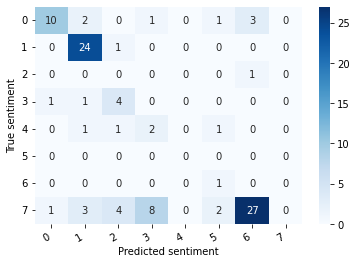

In [173]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_en_de)
valid_tags = MultiLabelBinarizer().fit_transform(valid_tags_de)
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [174]:
#EN-RU

In [175]:
def hypotheses(sent):
    pref = en_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [176]:
pred_tags_en_ru = []
for text in tqdm(final_texts_ru):    
    pred_tags_en_ru.append(get_ner(text))
print(f1_score(pred_tags_en_ru, final_tags_ru))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:06<00:00,  3.06s/it]

0.3087719298245614


In [177]:
print(classification_report(pred_tags_en_ru, final_tags_ru, digits=2))

              precision    recall  f1-score   support

        area       0.47      0.75      0.58        12
        food       0.89      0.26      0.40        98
  pricerange       0.67      0.16      0.25        51
        this       0.50      0.03      0.06        61

   micro avg       0.70      0.20      0.31       222
   macro avg       0.63      0.30      0.32       222
weighted avg       0.71      0.20      0.28       222



In [178]:
print(flat_classification_report(pred_tags_en_ru, final_tags_ru))

              precision    recall  f1-score   support

      B-area       0.47      0.75      0.58        12
      B-food       0.89      0.26      0.40        98
B-pricerange       0.67      0.16      0.25        51
      B-this       0.50      0.03      0.06        58
      I-this       1.00      0.08      0.14        26
           O       0.32      0.99      0.48        85

    accuracy                           0.39       330
   macro avg       0.64      0.38      0.32       330
weighted avg       0.63      0.39      0.32       330



In [179]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_en_ru)
valid_tags = MultiLabelBinarizer().fit_transform(final_tags_ru)

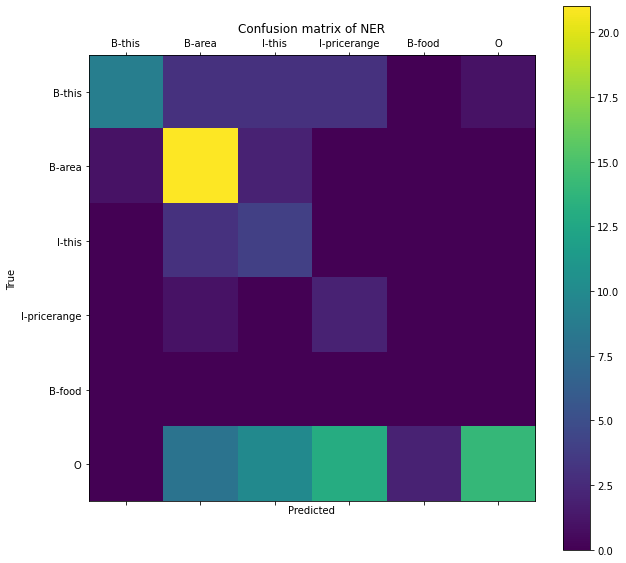

In [180]:
cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm)
plt.title('Confusion matrix of NER')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(tagset))
ax.set_yticklabels([''] + list(tagset))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

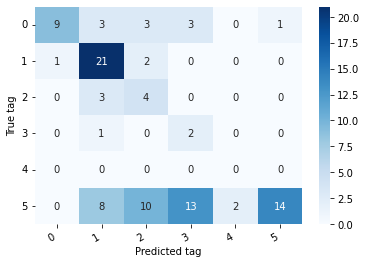

In [181]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True tag')
    plt.xlabel('Predicted tag');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [182]:
#DE-RU

In [183]:
def hypotheses(sent):
    pref = de_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [184]:
pred_tags_de_ru = []
for text in tqdm(final_texts_ru):    
    pred_tags_de_ru.append(get_ner(text))
print(f1_score(pred_tags_de_ru, final_tags_ru))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.49s/it]

0.20231213872832374


In [185]:
print(classification_report(pred_tags_de_ru, final_tags_ru, digits=2))

              precision    recall  f1-score   support

        area       0.79      0.12      0.20       129
        food       0.57      0.44      0.50        36
  pricerange       0.33      0.04      0.08        89
        this       0.00      0.00      0.00        29

   micro avg       0.56      0.12      0.20       283
   macro avg       0.42      0.15      0.20       283
weighted avg       0.54      0.12      0.18       283



In [186]:
print(flat_classification_report(pred_tags_de_ru, final_tags_ru))

              precision    recall  f1-score   support

      B-area       0.79      0.12      0.20       129
      B-food       0.57      0.44      0.50        36
B-pricerange       0.33      0.04      0.08        89
      B-this       0.00      0.00      0.00         0
      I-this       1.00      0.03      0.06        66
           O       0.04      1.00      0.07        10

    accuracy                           0.14       330
   macro avg       0.46      0.27      0.15       330
weighted avg       0.66      0.14      0.17       330



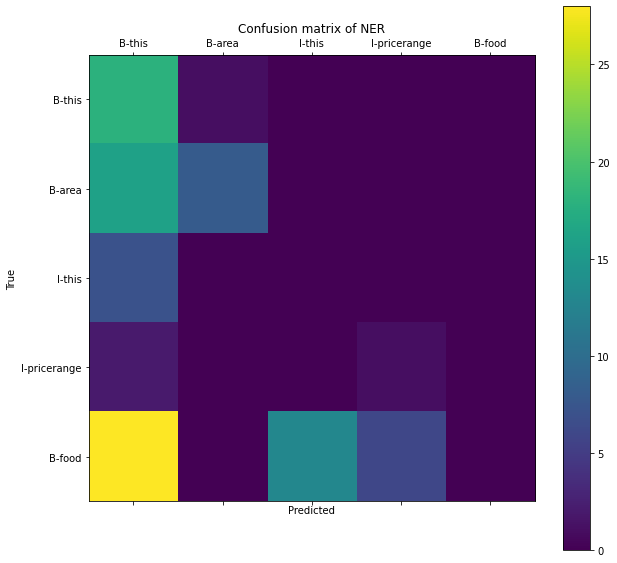

In [187]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_de_ru)
valid_tags = MultiLabelBinarizer().fit_transform(final_tags_ru)
cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm)
plt.title('Confusion matrix of NER')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(tagset))
ax.set_yticklabels([''] + list(tagset))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

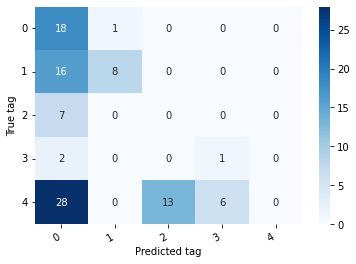

In [188]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True tag')
    plt.xlabel('Predicted tag');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [189]:
#RU-EN

In [190]:
def hypotheses(sent):
    pref = ru_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [191]:
pred_tags_ru_en = []
for text in tqdm(clean_texts_en):    
    pred_tags_ru_en.append(get_ner(text))
print(f1_score(pred_tags_ru_en, valid_tags_en))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [09:37<00:00,  5.78s/it]

0.14829659318637275


In [192]:
print(classification_report(pred_tags_ru_en, valid_tags_en, digits=2))

              precision    recall  f1-score   support

        area       0.12      0.67      0.20         3
        food       0.79      0.09      0.17       247
        name       0.00      0.00      0.00         0
  pricerange       0.67      0.07      0.12       177
        this       0.00      0.00      0.00         0

   micro avg       0.51      0.09      0.15       427
   macro avg       0.32      0.17      0.10       427
weighted avg       0.74      0.09      0.15       427



In [193]:
print(flat_classification_report(pred_tags_ru_en, valid_tags_en))

              precision    recall  f1-score   support

      B-area       0.12      0.67      0.20         3
      B-food       0.79      0.09      0.17       247
      B-name       0.00      0.00      0.00         0
B-pricerange       0.67      0.07      0.12       177
      B-this       0.00      0.00      0.00         0
      I-name       0.00      0.00      0.00         0
      I-this       0.00      0.00      0.00         0
           O       0.14      0.87      0.25        69

    accuracy                           0.20       496
   macro avg       0.22      0.21      0.09       496
weighted avg       0.65      0.20      0.16       496



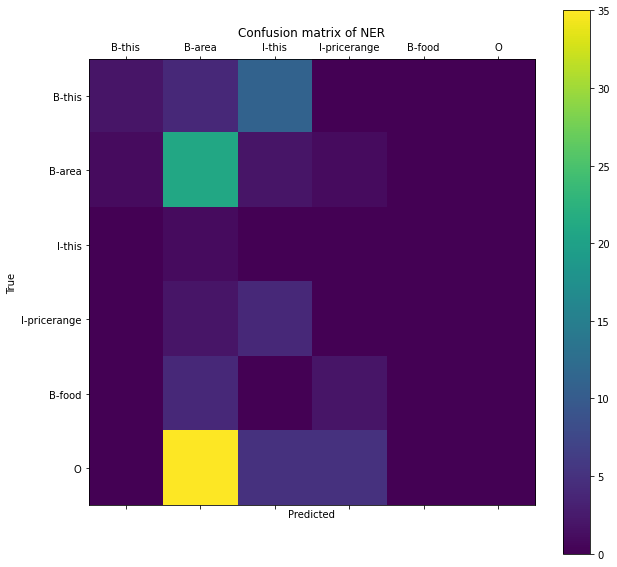

In [194]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_ru_en)
valid_tags = MultiLabelBinarizer().fit_transform(valid_tags_en)
cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm)
plt.title('Confusion matrix of NER')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(tagset))
ax.set_yticklabels([''] + list(tagset))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

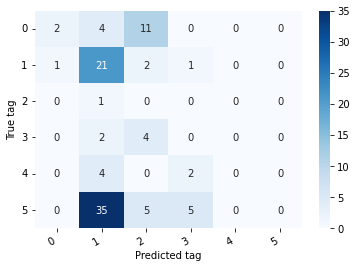

In [195]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True tag')
    plt.xlabel('Predicted tag');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [196]:
#DE-EN

In [197]:
def hypotheses(sent):
    pref = de_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [198]:
pred_tags_de_en = []
for text in tqdm(clean_texts_en):    
    pred_tags_de_en.append(get_ner(text))
print(f1_score(pred_tags_de_en, valid_tags_en))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [08:42<00:00,  5.22s/it]

0.18344519015659957


In [199]:
print(classification_report(pred_tags_de_en, valid_tags_en, digits=2))

              precision    recall  f1-score   support

        area       0.71      0.06      0.11       208
        food       0.59      0.37      0.45        46
        name       0.00      0.00      0.00         0
  pricerange       0.56      0.13      0.22        75
        this       0.29      0.04      0.08        46

   micro avg       0.57      0.11      0.18       375
   macro avg       0.43      0.12      0.17       375
weighted avg       0.61      0.11      0.17       375



In [200]:
print(flat_classification_report(pred_tags_de_en, valid_tags_en))

              precision    recall  f1-score   support

      B-area       0.71      0.06      0.11       208
      B-food       0.59      0.37      0.45        46
      B-name       0.00      0.00      0.00         0
B-pricerange       0.56      0.13      0.22        75
      B-this       0.00      0.00      0.00         0
      I-name       0.00      0.00      0.00         0
      I-this       0.50      0.03      0.05       153
           O       0.03      0.93      0.06        14

    accuracy                           0.11       496
   macro avg       0.30      0.19      0.11       496
weighted avg       0.59      0.11      0.14       496



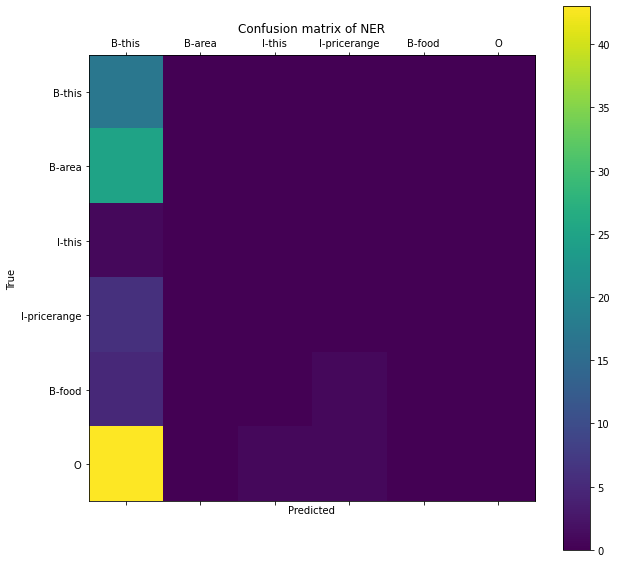

In [201]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_de_en)
valid_tags = MultiLabelBinarizer().fit_transform(valid_tags_en)
cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm)
plt.title('Confusion matrix of NER')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(tagset))
ax.set_yticklabels([''] + list(tagset))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

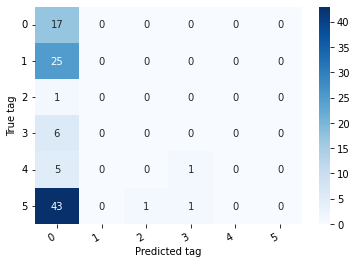

In [202]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True tag')
    plt.xlabel('Predicted tag');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [203]:
#RU-DE

In [204]:
def hypotheses(sent):
    pref = ru_data+sent
    hyps = [pref+tag for tag in tagset]
    return hyps, tagset

def choose_tag(sentence):
    losses = {}
    hyps, tagset = hypotheses(sentence)
    for tag, hyp in zip(tagset, hyps):
        input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
        model_output = model.forward(input_ids, labels=input_ids)
        losses[tag] = float(model_output["loss"].cpu().detach().numpy())
    return min(losses, key=losses.get)

def get_ner(text_to_tag):
    text_tokens = text_to_tag.split()
    sentence = ''
    text_tags = []
    result = {}
    for token in text_tokens:
        sentence += token+'_'
        next_tag = choose_tag(sentence)
        text_tags.append(next_tag)
        sentence += next_tag+ ' '
    for word, tag in zip(text_to_tag.split(), text_tags):
        result[word] = tag
    return text_tags

In [205]:
pred_tags_ru_de = []
for text in tqdm(clean_texts_de):    
    pred_tags_ru_de.append(get_ner(text))
print(f1_score(pred_tags_ru_de, valid_tags_de))

100%|████████████████████████████████████████████████████████████████████████| 100/100 [08:57<00:00,  5.37s/it]

0.23563218390804597


In [206]:
print(classification_report(pred_tags_ru_de,valid_tags_de, digits=2))

              precision    recall  f1-score   support

        area       0.59      0.77      0.67        13
        food       0.81      0.16      0.27       155
        name       0.00      0.00      0.00         0
  pricerange       0.32      0.06      0.10       103
        this       0.00      0.00      0.00         0

   micro avg       0.53      0.15      0.24       271
   macro avg       0.34      0.20      0.21       271
weighted avg       0.61      0.15      0.22       271



In [207]:
print(flat_classification_report(pred_tags_ru_de,valid_tags_de))

              precision    recall  f1-score   support

      B-area       0.59      0.77      0.67        13
      B-food       0.81      0.16      0.27       155
      B-name       0.00      0.00      0.00         0
B-pricerange       0.32      0.06      0.10       103
      B-this       0.00      0.00      0.00         0
      I-name       0.00      0.00      0.00         0
      I-this       0.00      0.00      0.00         0
           O       0.50      0.95      0.65       199

    accuracy                           0.49       470
   macro avg       0.28      0.24      0.21       470
weighted avg       0.56      0.49      0.41       470



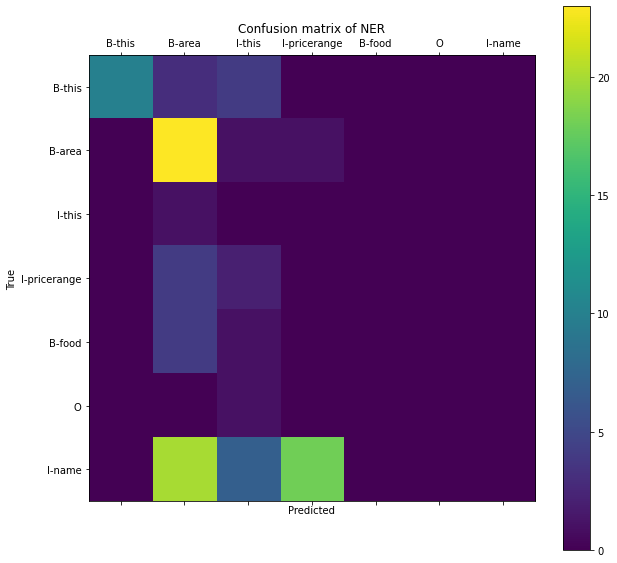

In [208]:
pred_tags = MultiLabelBinarizer().fit_transform(pred_tags_ru_de)
valid_tags = MultiLabelBinarizer().fit_transform(valid_tags_de)
cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm)
plt.title('Confusion matrix of NER')
fig.colorbar(cax)
ax.set_xticklabels([''] + list(tagset))
ax.set_yticklabels([''] + list(tagset))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

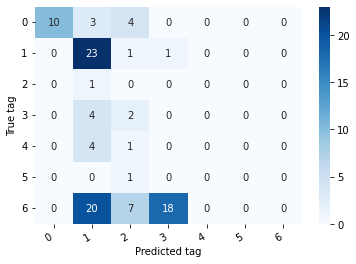

In [209]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True tag')
    plt.xlabel('Predicted tag');

cm = confusion_matrix(valid_tags.argmax(axis=1), pred_tags.argmax(axis=1))
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [210]:
# def hypotheses(test_data):
#     pref = train_data+test_data
#     hyps = [pref+tag for tag in tagset]
#     return hyps, tagset

# def choose_tag(sentence):
#     losses = {}
#     hyps, tagset = hypotheses(sentence)

#     for tag, hyp in zip(tagset, hyps):
#         input_ids = tokenizer.encode(hyp, return_tensors='pt').cuda(device)
#         model_output = model.forward(input_ids, labels=input_ids)
#         losses[tag] = float(model_output["loss"].cpu().detach().numpy())
#     return dict(sorted(losses.items(), key=lambda item: item[1])[:3])

# def get_ner_tagger(text_to_tag):
#     text_tokens = text_to_tag.split()
#     sentences = [('',0.)]
#     text_tags = []
#     for token in text_tokens:
#         new_sentences = []
#         for sentence, sentence_proba in sentences:
#             sentence += token+'_'
#             next_tags = choose_tag(sentence)
#             for next_tag, next_tag_proba in next_tags.items():
#                 sentence_clone = sentence
#                 sentence_clone += next_tag+ ' '
#                 new_sentences.append((sentence_clone, next_tag_proba))
#         sentences = new_sentences
#     #print(dict(sentences))
#     return dict(sorted(dict(sentences).items(), key=lambda item: item[1])[:10])

In [211]:
# get_ner_tagger('cheap restaurant in the city centre')

In [212]:
#ТУТ ПОШЛИ МОИ КЕКСПЕРИМЕНТЫ

In [213]:
# text = """
#         [Text]: food
#         [Tags]: O
#         ###
#         [Text]: japanese
#         [Tags]: B-food
#         ###
#         [Text]: Ich
#         [Tags]: O
#         ###
#         [Text]: south
#         [Tags]: B-area
#         ###
#         [Text]: moderate
#         [Tags]: B-pricerange]
#         ###
#         [Text]: address
#         [Tags]: O]
#         ###
#         [Text]: downtown
#         [Tags]: B-area
#         ###
#         [Text]: town
#         [Tags]: O
#         ###
#         [Text]: cheap
#         [Tags]: B-pricerange
#         ###
#         [Text]: want
#         [Tags]: O
#         ###
#         [Text]: expensive
#         [Tags]:"""

# input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
# out = model.generate(input_ids,
#                     max_length=690,         # max length of final sequence
#                     do_sample=False,        # randomly pick next word according to probability distribution
#                     repetition_penalty=0.1,  # discounts the scores of previously generated tokens (1 == do not apply)
#                     pad_token_id=50256)    

# generated_text = list(map(tokenizer.decode, out))[0]
# print(generated_text)